## Notes

Grab university dataset from Kaggle  
Scrape wikipedia to confirm endowment and get university age. use regex to get widdle down to the year.
Select intuitively relevant admissions features, Add data with average family income
Pairplot and heatmap matrix for multicolinearity
QQ plot y, sqrt y, log y
run naive regression

engineer total SAT, and proportion of SAT that is for math and verbal as features
run linear regression with variable selection

polynomial regression
ridge regression
cross validation

insights

In [240]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from bs4 import BeautifulSoup
import requests
import re

In [241]:
feature_list=[
    'Name',
    'SAT Critical Reading 75th percentile score',
    'SAT Math 75th percentile score',
    'SAT Writing 75th percentile score',
    'Percent admitted - total',
    'Admissions yield - total',
    'Tuition and fees, 2013-14',
    'Control of institution',
    'Undergraduate enrollment',
    'Graduate enrollment',
    'Graduation rate - Bachelor degree within 5 years, total',
    'Percent of freshmen receiving any financial aid',
    'Endowment assets (year end) per FTE enrollment (GASB)',
    'Endowment assets (year end) per FTE enrollment (FASB)'
]

feature_list_simple=[
    'college',
    'sat_reading_75',
    'sat_math_75',
    'sat_writing_75',
    'admission_rate',
    'admission_yield',
    'tuition',
    'control',
    'undergrad_enrollment',
    'grad_enrollment',
    'graduation_rate',
    'financialaid_rate',
    'endowment1',
    'endowment2'
]

In [298]:
df = pd.read_csv('admissions.csv')
# select a subset of features
df = df.loc[:,feature_list]

# rename columns
df.columns = feature_list_simple

df['endowment'] = df.loc[:,['endowment1','endowment2']].max(axis=1)

# drop colleges with missing vals for any of those features, except for endowment
df = df.dropna(subset = feature_list_simple[:-2] + ['endowment'])

df.drop(['endowment1','endowment2'],inplace=True,axis=1)

In [299]:
oi = pd.read_csv('mrc_table3.csv').loc[:,['name','par_mean','par_median','k_mean','k_median']]
oi = oi.groupby('name', as_index=False).mean()
oi.name = oi.name.str.replace(',',' ').str.lower()
oi.name = oi.name.str.replace('-',' ').str.lower()
oi.name = oi.name.replace('\s+', ' ', regex=True)

df.college = df.college.str.replace(',',' ').str.lower()
df.college = df.college.str.replace('-',' ').str.lower()
df.college = df.college.replace('\s+', ' ', regex=True)
df[df.college.str.contains('cal')]


,college,sat_reading_75,sat_math_75,sat_writing_75,admission_rate,admission_yield,tuition,control,undergrad_enrollment,grad_enrollment,graduation_rate,financialaid_rate,endowment
35,embry riddle aeronautical university prescott,630.0,650.0,600.0,79.0,34.0,31034.0,Private not-for-profit,1879.0,42.0,56.0,91.0,11293.0
63,california baptist university,550.0,560.0,540.0,79.0,33.0,28122.0,Private not-for-profit,5797.0,1347.0,54.0,95.0,2304.0
64,california institute of technology,800.0,800.0,790.0,11.0,43.0,41538.0,Private not-for-profit,977.0,1204.0,90.0,73.0,872856.0
81,university of california berkeley,720.0,770.0,750.0,18.0,37.0,12864.0,Public,25951.0,10247.0,89.0,69.0,36917.0
82,university of california davis,640.0,680.0,650.0,45.0,23.0,13895.0,Public,26533.0,6774.0,77.0,77.0,7855.0
83,university of california irvine,600.0,670.0,620.0,42.0,21.0,13149.0,Public,23530.0,5365.0,84.0,77.0,8945.0
84,university of california los angeles,680.0,760.0,710.0,22.0,35.0,12697.0,Public,28674.0,12121.0,88.0,62.0,34375.0
85,university of california riverside,580.0,630.0,590.0,62.0,21.0,12960.0,Public,18621.0,2586.0,62.0,86.0,5387.0
86,university of california san diego,660.0,730.0,690.0,38.0,20.0,13271.0,Public,23805.0,5712.0,81.0,62.0,15714.0
87,university of california santa barbara,650.0,690.0,660.0,44.0,19.0,13746.0,Public,19362.0,2863.0,79.0,70.0,5527.0


In [86]:
# Not super robust scrape of wikipedia

founded_dates = []
wiki_endowments = []
badcollege = []

for college in df.college:
    college = college.replace(' ','_')
    url = f'https://en.wikipedia.org/wiki/{college}'
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")

    try:
        table = soup.find('table',attrs={'class': 'infobox vcard'}).find('tbody')
        founded_date = table.find('th',string='Established').next_sibling.text
        wiki_endowment = table.find('th',string='Endowment').next_sibling.text
        founded_dates.append(founded_date)
        wiki_endowments.append(wiki_endowment)
            
    except:
        founded_dates.append('Error')
        wiki_endowments.append('Error')
        badcollege.append(college)

In [300]:
df ['Endowment_wikipedia'] = wiki_endowments
df ['Founded'] = founded_dates

In [301]:
df2 = df.merge(oi,left_on='college',right_on='name')
len(df2)

475

In [303]:
df2.to_pickle('endowment.pkl')


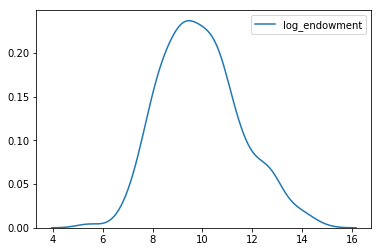

In [209]:
sns.kdeplot(df.log_endowment)

In [10]:
y1, X1 = patsy.dmatrices('endowment~sat_reading_75+sat_math_75+sat_writing_75+admission_rate+admission_yield+tuition+control+undergrad_enrollment+grad_enrollment+graduation_rate+financialaid_rate', data=df, return_type="dataframe")
y2, X2 = patsy.dmatrices('log_endowment~sat_math_75+admission_rate+admission_yield+tuition', data=df, return_type="dataframe")
y3, X3 = patsy.dmatrices('logsqrt_endowment~sat_math_75+admission_rate+admission_yield+tuition', data=df, return_type="dataframe")
y4, X4 = patsy.dmatrices('log_endowment~sat_reading_75+sat_math_75+sat_writing_75+admission_rate+admission_yield+tuition+control+undergrad_enrollment+grad_enrollment+graduation_rate+financialaid_rate', data=df, return_type="dataframe")

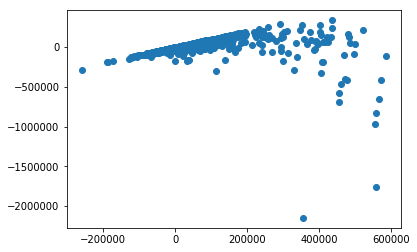

In [89]:
# Fit and summarize OLS model
model1 = sm.OLS(y1, X1)
fit1 = model1.fit()
fit1.summary()
pred1 = fit1.predict(X1)
res1 = np.array(pred1).reshape(693,1) - np.array(y1)

plt.scatter(pred1,res1);
plt.show()
#sm.qqplot(res1)

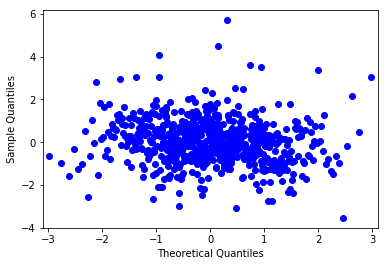

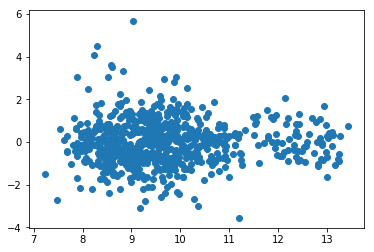

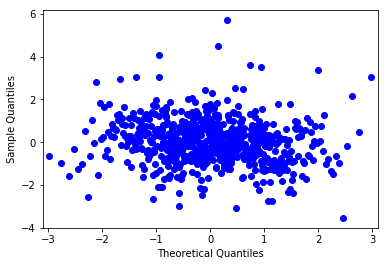

In [90]:
model2 = sm.OLS(y2, X2)
fit2 = model2.fit()
fit2.summary()
pred2 = fit2.predict(X2)
res2 = np.array(pred2).reshape(693,1) - np.array(y2)
plt.scatter(pred2,res2);

sm.qqplot(res2)

In [ ]:
model4 = sm.OLS(y4, X4)
fit4 = model4.fit()
fit4.summary()
pred4 = fit4.predict(X4)
res4 = np.array(pred4).reshape(693,1) - np.array(y4)
plt.scatter(pred4,res4);

sm.qqplot(res4)